In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel, f_oneway,ttest_1samp
from dataset import *

from statsmodels.stats.anova import AnovaRM # perform F test

In [2]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'


language_dir = '/srv/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists():
    language_dir = '/cifs/diedrichsen/data/Cerebellum/Language'
if not Path(language_dir).exists:
    language_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/Language'

## ROI (group language localizer thresholded top 10%)

In [3]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    g_df['err'] = g_std['res']
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50)
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=True, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # put the errorbars in 
    g.map(plt.errorbar, x = df_preped['X'], 
                        y = df_preped['Y'], 
                        yerr = df_preped['err'],
                        elinewidth=1, 
                        fmt='none', # no marker will be used when plotting the error bars
                        color='grey', 
                        ecolor='0.9'
                )
    # set labels
    g.set_xlabels('Cortical Activation (a.u.)')
    g.set_ylabels('Cerebellar Activation (a.u.)')


In [5]:
# load the dataframe for the whole 
df_path = os.path.join(language_dir, "Fedorenko/dataframes", "fedorenko_roi.tsv")
df = pd.read_csv(df_path, sep="\t")
print(df)
df_averaged = df.groupby(['sn', 'cond_name']).mean()
df_averaged = df_averaged.reset_index()


     sub_id  sn       cond_name  cond_num         X         Y  residual
0       261   0  ProdE1_NProd_t         0  0.037549  0.002715 -0.001048
1       261   0  ProdE1_SProd_t         1  0.068965  0.007030 -0.000101
2       261   0  ProdE1_WProd_t         2  0.046363  0.004687 -0.000021
3       261   0  ProdE1_SComp_t         3  0.012559  0.001210  0.000126
4       261   0  ProdE1_WComp_t         4  0.043800  0.005477  0.001044
..      ...  ..             ...       ...       ...       ...       ...
135     831  27  ProdE1_NProd_t         0 -0.007629 -0.000319 -0.001902
136     831  27  ProdE1_SProd_t         1  0.054199  0.002569 -0.001248
137     831  27  ProdE1_WProd_t         2  0.030124  0.004206  0.001259
138     831  27  ProdE1_SComp_t         3  0.007521  0.002877  0.000746
139     831  27  ProdE1_WComp_t         4  0.008395  0.003307  0.001145

[140 rows x 7 columns]


/tmp/ipykernel_798548/3647883168.py:11: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in sn_groups:


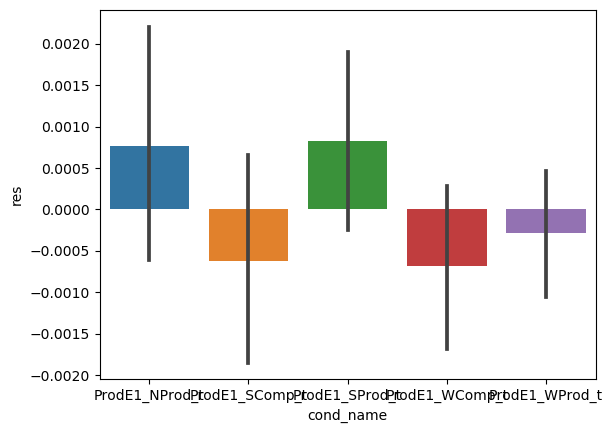

In [6]:
df_residuals = df_averaged.copy()

#create new columns to store the slope and intercept
df_residuals['slope'] = np.nan
df_residuals['intercept'] = np.nan

#group the dataframe by sn
sn_groups = df_residuals.groupby(['sn'])

#calculate slope and intercept for each subject
for name, group in sn_groups:
    # fit linear reg model
    slope, intercept = np.polyfit(group['X'], group['Y'], 1)
    # save values
    df_residuals.loc[df_residuals['sn'] == name, 'slope'] = slope
    df_residuals.loc[df_residuals['sn'] == name, 'intercept'] = intercept

# calcualte each res
for index, row in df_residuals.iterrows():

    Y_pred = row['slope'] * row['X'] + row['intercept']

    res = row['Y'] - Y_pred

    df_residuals.loc[index, 'Y_pred'] = Y_pred
    df_residuals.loc[index, 'res'] = res

sns.barplot(data=df_residuals,x='cond_name',y='res')

In [7]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean, 'res': np.mean}
df_preped = prep_df(df_residuals ,groupby = "cond_name", agg_kw=agg_kw)


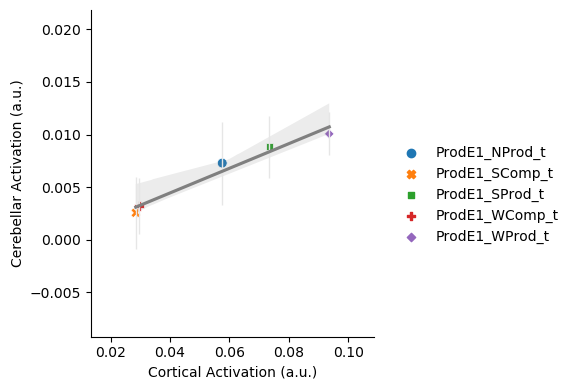

In [8]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)

In [9]:
# need to pass on aggregate_func to aggregate over the two halved (see half column in the original dataframe)
print(AnovaRM(data=df_residuals, depvar='res',
              subject='sn', within=['cond_name'], aggregate_func = np.mean).fit())

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
cond_name  1.2998 4.0000 108.0000 0.2748

